# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json
from collections import deque

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [4]:
from dataloaders import dataset_ST_MultiPoint
# from dataloaders import load_dataset
# from loss import losses_SparseData
# from models import models_SparseData
# from optimizer import load_optimizer

from subprocess import Popen

# Load dictionary

In [5]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/ST_MultiPoint/ST_MultiPoint_DisNet_K_CDiff_Losses_0.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:0', 'entity': 'gsartor-unito', 'experiment_name': 'ST_MultiPoint', 'run_name': 'ST_MultiPoint_DisNet_K_CDiff_Losses', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_ST_MultiPoint/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_ST_MultiPoint/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_2000_2023.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI_arpa_weather.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'ST_MultiPoint', 'piezo_head': True, 'relative_target': False, 'nan_treshold': 10, 'fill_value': 0, 'normalizat

# Dataset class

In [6]:
importlib.reload(dataset_ST_MultiPoint)

<module 'dataloaders.dataset_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_ST_MultiPoint.py'>

In [7]:
ds = dataset_ST_MultiPoint.Dataset_ST_MultiPoint(dict_files)

    Loading weather data... 

Done!
    Loading dtm... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_means': np.float64(298.19569411165224), 'target_stds': np.float64(73.65282819016454), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.8125), 'lat_std': np.float64(0.3227486121839514), 'lon_mean': np.float64(7.375), 'lon_std': np.float64(0.43150656619183286), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    prec         float32 4B 2.55
    tmax         float32 4B 13.33
    tmin         float32 4B 5.437
    tmean        float32 4B 9.383, 'weather_std': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data v

# Model 

In [14]:
from models import models_ST_MultiPoint
importlib.reload(models_ST_MultiPoint)
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)

<module 'models.load_model_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model_ST_MultiPoint.py'>

In [15]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [16]:
model, _ = load_model_ST_MultiPoint.load_model(dict_files)

Model: ST_MultiPoint_DisNet_K


In [17]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad and p != "Densification_Dropout"))

Total number of trainable parameters:  321668


In [18]:
# load weights
model_name_path = "model_ST_MultiPoint_DisNet_K_20250823_194545" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_ST_MultiPoint/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

ST_MultiPoint_DisNet_K(
  (activation_fn): LeakyReLU(negative_slope=0.01)
  (Value_Embedding_GW): Embedding(
    (activation): LeakyReLU(negative_slope=0.01)
    (ST_layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LeakyReLU(negative_slope=0.01)
      (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LeakyReLU(negative_slope=0.01)
    )
  )
  (Value_Embedding_Weather): Embedding(
    (activation): LeakyReLU(negative_slope=0.01)
    (ST_layers): Sequential(
      (0): Linear(in_features=9, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LeakyR

## Grid prediction

In [19]:
from utils import plot_ST_MultiPoint
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [20]:
lat_points = 42
lon_points = 62
z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [21]:
_ , Y_hat_test, Z_pred = plot_ST_MultiPoint.compute_predictions_MultiPoint(np.datetime64("2023-09-03"),
                                         ds,
                                         model,
                                         device,
                                         Z_grid = z_grid,
                                         get_Z = True)

In [22]:
coords = Z_pred.reshape(lat_points,lon_points,5)
Y_hat_test_grid = Y_hat_test.reshape(lat_points,lon_points)

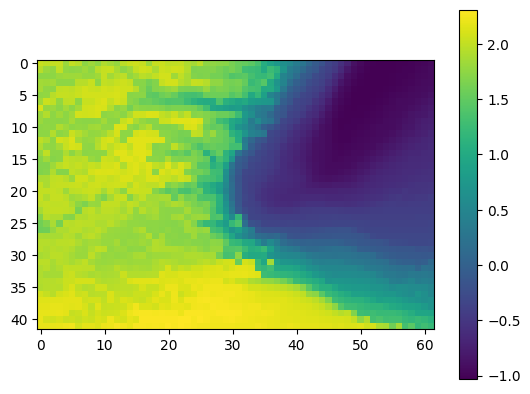

In [23]:
plt.imshow(Y_hat_test_grid)
plt.colorbar()

In [24]:
sensor_idx = 8
sensor = ds.sensor_id_list[sensor_idx]
munic = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"munic"].values[0]
sensor_coords = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"geometry"]
sensor_x = sensor_coords.x.values[0]
print(sensor_x)
sensor_y = sensor_coords.y.values[0]
print(sensor_y)

7.534462842811861
45.01630171626975


In [38]:
ds[0][1][1]

tensor([[[[ 1.5492e+00,  1.5492e+00,  1.5492e+00,  ...,  1.5492e+00,
            1.5492e+00,  1.5492e+00],
          [ 1.1619e+00,  1.1619e+00,  1.1619e+00,  ...,  1.1619e+00,
            1.1619e+00,  1.1619e+00],
          [ 7.7460e-01,  7.7460e-01,  7.7460e-01,  ...,  7.7460e-01,
            7.7460e-01,  7.7460e-01],
          ...,
          [-7.7460e-01, -7.7460e-01, -7.7460e-01,  ..., -7.7460e-01,
           -7.7460e-01, -7.7460e-01],
          [-1.1619e+00, -1.1619e+00, -1.1619e+00,  ..., -1.1619e+00,
           -1.1619e+00, -1.1619e+00],
          [-1.5492e+00, -1.5492e+00, -1.5492e+00,  ..., -1.5492e+00,
           -1.5492e+00, -1.5492e+00]],

         [[ 1.5492e+00,  1.5492e+00,  1.5492e+00,  ...,  1.5492e+00,
            1.5492e+00,  1.5492e+00],
          [ 1.1619e+00,  1.1619e+00,  1.1619e+00,  ...,  1.1619e+00,
            1.1619e+00,  1.1619e+00],
          [ 7.7460e-01,  7.7460e-01,  7.7460e-01,  ...,  7.7460e-01,
            7.7460e-01,  7.7460e-01],
          ...,
     

## FDif trials

In [ ]:
K = torch.ones_like(Y_hat_test_grid)
Lag_GW_t = Y_hat_test_grid[None,None,:,:]
        
dh_dy = Fdiff_conv(Lag_GW_t, mode = "first_lat")
dh_dx = Fdiff_conv(Lag_GW_t, mode = "first_lon")

dh_dy = dh_dy * K[None,None,:,:]
dh_dx = dh_dx * K[None,None,:,:]

dh_dydy = Fdiff_conv(dh_dy, mode = "first_lat")
dh_dxdx = Fdiff_conv(dh_dx, mode = "first_lon")

spatial_grad = dh_dydy + dh_dxdx

## ST Grid

In [14]:
date = np.datetime64("2006-01-01")
n_pred = 12
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred)

  8%|▊         | 1/12 [00:00<00:09,  1.21it/s]

100%|██████████| 12/12 [00:03<00:00,  3.06it/s]


In [15]:
predictions.shape

torch.Size([12, 28])

In [17]:
_, predictions_grid = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred,
                                                    iter_pred = False,
                                                    Z_grid = z_grid)

100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


In [18]:
coords = z_grid.reshape(lat_points,lon_points,3)

In [20]:
predictions_grid = predictions_grid.reshape(n_pred,lat_points,lon_points)

In [22]:
start_date_idx = ds.dates.get_loc(np.datetime64(date))
date_seq = [ds.dates[start_date_idx+i] for i in range(n_pred)]
predictions_grid_xr = xarray.DataArray(data = predictions_grid,
                                coords = dict(
                                            lat=("lat", coords[:,0,0]),
                                            lon=("lon", coords[0,:,1]),
                                            time=date_seq),
                                dims = ["time","lat", "lon"]
                                )

In [ ]:
predictions_grid_xr.sel()

## Displacement

In [25]:
from models import models_ST_MultiPoint
importlib.reload(models_ST_MultiPoint)
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)
# dict_files["model_init"] = None
# model, _ = load_model_ST_MultiPoint.load_model(dict_files)

<module 'models.load_model_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model_ST_MultiPoint.py'>

In [26]:
_ , Y_hat_test, Displacement_GW, Displacement_S, Permeability, Lag_GW, Z_pred = plot_ST_MultiPoint.compute_predictions_MultiPoint(np.datetime64("2022-02-06"),
                                         ds,
                                         model,
                                         device,
                                         Z_grid = z_grid,
                                         get_Z = True,
                                         get_displacement_terms = True)

In [29]:
Y_hat_test_grid = Y_hat_test.reshape(lat_points,lon_points)
Displacement_GW_grid = Displacement_GW.reshape(lat_points,lon_points)
Displacement_S = Displacement_S.reshape(lat_points,lon_points)
Lag_GW = Lag_GW.reshape(4,lat_points,lon_points)
Permeability = Permeability.reshape(lat_points,lon_points)

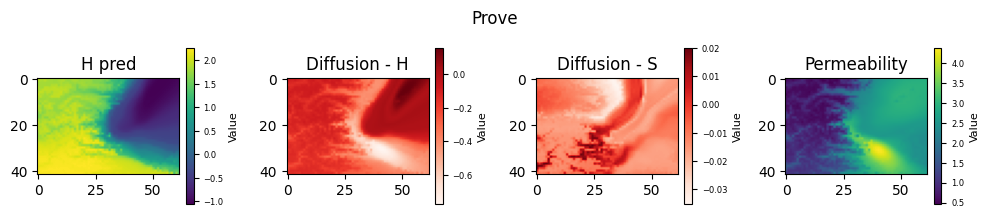

In [30]:
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0)

fig, ax = plt.subplots(1,4, figsize = (10,5))

plt.suptitle("Prove", y = 0.7)

im1 = ax[0].imshow(Y_hat_test_grid)
ax[0].set_title("H pred")
cbar = plt.colorbar(im1, ax = ax[0], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im2 = ax[1].imshow(Displacement_GW_grid, cmap = "Reds",# norm = norm
                   )
ax[1].set_title("Diffusion - H")
cbar = plt.colorbar(im2, ax = ax[1], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im3 = ax[2].imshow(Displacement_S, cmap = "Reds",# norm = norm
                   )
ax[2].set_title("Diffusion - S")
cbar =plt.colorbar(im3, ax = ax[2], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im4 = ax[3].imshow(Permeability)
ax[3].set_title("Permeability")
cbar = plt.colorbar(im4, ax = ax[3], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

plt.tight_layout()

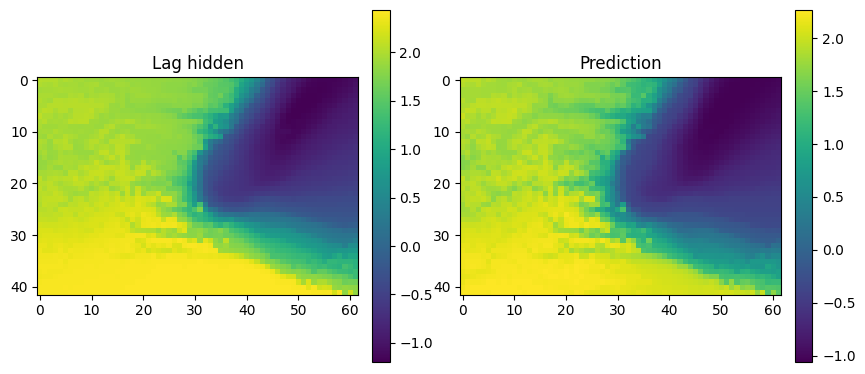

In [33]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

im0 = ax[0].imshow(Lag_GW[-1],# vmin = Y_hat_test_grid.min(), vmax = Y_hat_test_grid.max()
                   )
ax[0].set_title("Lag hidden")
cbar = plt.colorbar(im0, ax = ax[0], fraction=0.05, pad=0.04)

im1 = ax[1].imshow(Y_hat_test_grid, vmin = Y_hat_test_grid.min(), vmax = Y_hat_test_grid.max())
ax[1].set_title("Prediction")
cbar = plt.colorbar(im1, ax = ax[1], fraction=0.05, pad=0.04)


In [34]:
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [16]:
lat_points = 42
lon_points = 62
Z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [17]:
date = np.datetime64("2021-07-04")
n_pred = 4
true, predictions, Displacement_GW, Displacement_S, Permeability, Lag_GW = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred,
                                                                        get_displacement_terms = True,
                                                                        Z_grid = Z_grid)

100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


In [18]:
predictions.shape

torch.Size([4, 2604])

In [20]:
torch.diff(predictions, n=1, dim=0)

tensor([[-0.0630, -0.0607, -0.0611,  ..., -0.0319, -0.0308, -0.0307],
        [-0.1181, -0.1211, -0.1206,  ..., -0.1187, -0.1189, -0.1189],
        [ 0.0430,  0.0478,  0.0462,  ...,  0.0448,  0.0445,  0.0440]])

In [128]:
predictions_grid = predictions.reshape(4,lat_points,lon_points)
Displacement_GW_grid = Displacement_GW.reshape(4,lat_points,lon_points)
Displacement_S_grid = Displacement_S.reshape(4,lat_points,lon_points)
Permeability_grid = Permeability.reshape(4,lat_points,lon_points)
Lag_GW = Lag_GW.reshape(4,lat_points,lon_points)

In [129]:
start_date_idx = ds.dates.get_loc(np.datetime64(date))
date_seq = [ds.dates[start_date_idx+i] for i in range(n_pred)]

Z_grid_matrix = Z_grid.reshape(lat_points,lon_points,3)
Z_grid_matrix_lat = Z_grid_matrix[:,:,0]
Z_grid_matrix_lon = Z_grid_matrix[:,:,1]
dtm = Z_grid_matrix[:,:,2]
                
predictions_xr = xarray.DataArray(data = predictions_grid,
                                coords = dict(
                                            lat=("lat", Z_grid_matrix_lat[:,0]),
                                            lon=("lon", Z_grid_matrix_lon[0,:]),
                                            time=date_seq),
                                dims = ["time","lat", "lon"]
                                )
            
displacement_gw_xr = xarray.DataArray(data = Displacement_GW_grid,
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )

displacement_s_xr = xarray.DataArray(data = Displacement_S_grid,
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )

permeability_xr = xarray.DataArray(data = Permeability_grid,
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )
Lag_GW_xr = xarray.DataArray(data = Lag_GW,
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )

In [90]:
ds.norm_factors["lat_mean"]

np.float64(44.8125)

In [130]:
from matplotlib.colors import TwoSlopeNorm

def plot_pred_displacement_maps(predictions_xr,
            predictions_xr_wtd,
            displacement_gw_xr,
            displacement_s_xr,
            permeability_xr,
            title,
            vmin = None,
            vmax = None,
            save_dir = None, 
            print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,5, figsize = (12,2.5))
    fig.suptitle(title)
    
    if vmin is None:
        vmin_H = predictions_xr.min().values
        vmin_WTD = predictions_xr_wtd.min().values
    else:
        vmin_H = vmin[0]
        vmin_WTD = vmin[1]
    
    if vmax is None:
        vmax_H = predictions_xr.max().values
        vmax_WTD = predictions_xr_wtd.max().values
    else:
        vmax_H = vmax[0]
        vmax_WTD = vmax[1]

    im0 = predictions_xr.plot(ax = ax[0],
                vmin = vmin_H,
                vmax = vmax_H)
    ax[0].set_title("Prediction H [m]")
    ax[0].tick_params(labelsize=6)  # Set tick label size
    
    
    im1 = predictions_xr_wtd.plot(ax = ax[1],
                vmin = vmin_WTD,
                vmax = vmax_WTD)
    ax[1].set_title("Prediction WTD [m]")
    ax[1].tick_params(labelsize=6)  # Set tick label size
    
    norm = TwoSlopeNorm(vcenter=0)
    
    im2 = displacement_gw_xr.plot(ax = ax[2],
                cmap = "seismic_r",# norm = norm
                )
    ax[2].set_title("Displacement - H [m]")
    ax[2].tick_params(labelsize=6)  # Set tick label size
    
    im3 = displacement_s_xr.plot(ax = ax[3],
                cmap = "seismic_r",# norm = norm
                )
    ax[3].set_title("Displacement - S [m]")
    ax[3].tick_params(labelsize=6)  # Set tick label size
    
    im4 = permeability_xr.plot(ax = ax[4])
    ax[4].set_title("Permeability [m/w]")
    # cbar = plt.colorbar(im4, ax = ax[4], fraction=0.05, pad=0.04)
    ax[4].tick_params(labelsize=6)  # Set tick label size

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

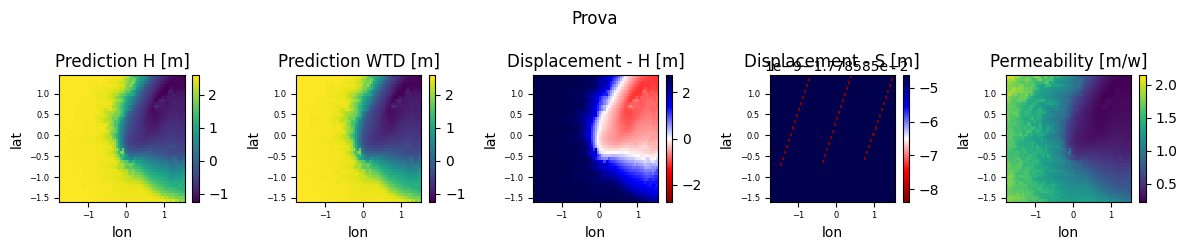

In [131]:
plot_pred_displacement_maps(predictions_xr[0],
            predictions_xr[0],
            displacement_gw_xr[0],
            displacement_s_xr[0],
            permeability_xr[0],
            title = "Prova",
            print_plot = True)

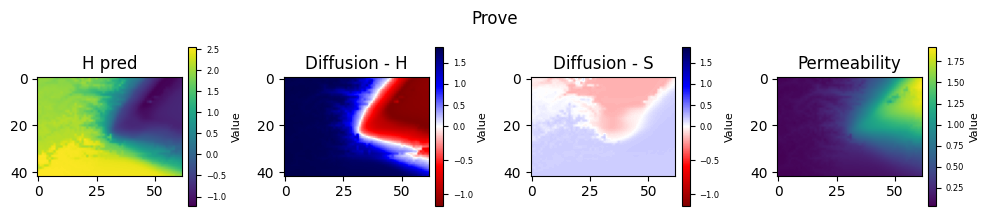

In [66]:
fig, ax = plt.subplots(1,4, figsize = (10,5))

tstep = 3

plt.suptitle("Prove", y = 0.7)

im1 = ax[0].imshow(predictions_grid[tstep])
ax[0].set_title("H pred")
cbar = plt.colorbar(im1, ax = ax[0], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im2 = ax[1].imshow(Displacement_GW_grid[tstep], cmap = "seismic_r", norm = norm)
ax[1].set_title("Diffusion - H")
cbar = plt.colorbar(im2, ax = ax[1], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im3 = ax[2].imshow(Displacement_S_grid[tstep], cmap = "seismic_r", norm = norm)
ax[2].set_title("Diffusion - S")
cbar =plt.colorbar(im3, ax = ax[2], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im4 = ax[3].imshow(Permeability_grid[tstep])
ax[3].set_title("Permeability")
cbar = plt.colorbar(im4, ax = ax[3], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

plt.tight_layout()

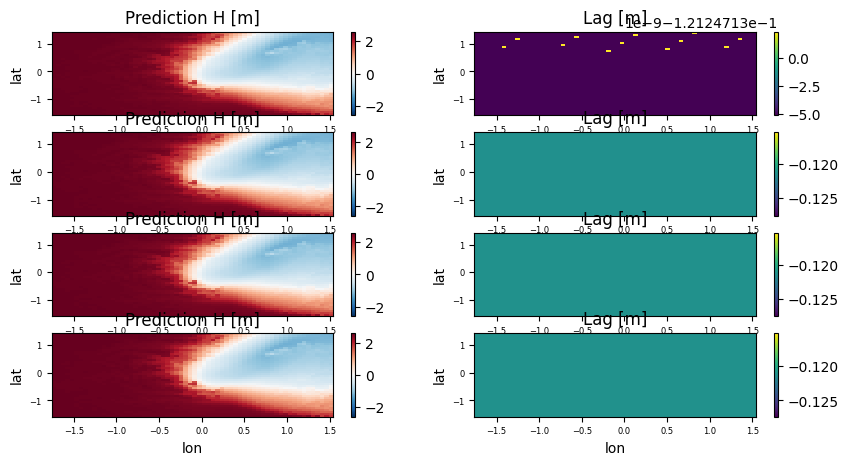

In [132]:
fig, ax = plt.subplots(4,2, figsize = (10,5))

tstep = 3


for tstep in range(4):

    predictions_xr[tstep].plot(ax = ax[tstep,0])
    ax[tstep,0].set_title("Prediction H [m]")
    ax[tstep,0].tick_params(labelsize=6)  # Set tick label size
    
    Lag_GW_xr[tstep].plot(ax = ax[tstep,1])
    ax[tstep,1].set_title("Lag [m]")
    ax[tstep,1].tick_params(labelsize=6)  # Set tick label size

## Time Series

In [35]:
from utils import plot_ST_MultiPoint
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [36]:
date = np.datetime64("2016-01-03")
n_pred = 20
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred)

100%|██████████| 20/20 [00:03<00:00,  6.41it/s]


In [37]:
_, predictions_iter = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred, iter_pred = True)

100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


In [38]:
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
true_ds = (true_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
pred_ds = (pred_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
# pred_iter_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions_iter, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
# pred_iter_ds = (pred_iter_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

In [39]:
true_ds[sensor].isna().all()

np.False_

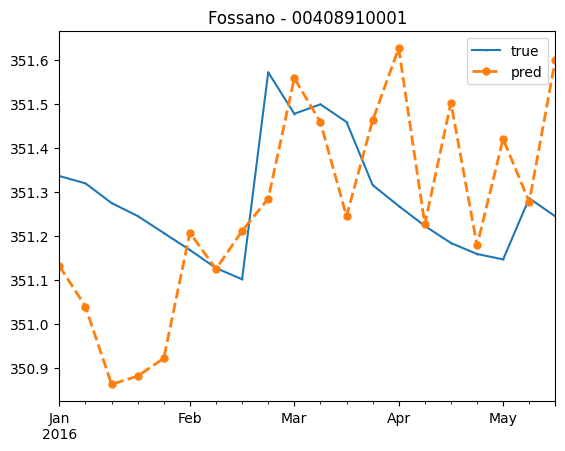

In [40]:
sensor_idx = 20
sensor = ds.sensor_id_list[sensor_idx]
munic = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"munic"].values[0]

fig, ax = plt.subplots(1,1)
min = np.inf
max = 0
true_ds[sensor].plot(label = "true", ax = ax, marker = "o", markersize = 0.5)
pred_ds[sensor].plot(label = "pred", ax = ax, marker = "o",  linestyle = "--" , markersize = 5, linewidth = 2)
#pred_iter_ds[sensor].plot(label = "pred_iter")
plt.title(f"{munic} - {sensor}")

# if true_ds[sensor].isna().all():
#     if min 
#     min_ = pred_ds[sensor].min(skipna=True)*(1-0.025)
#     max = pred_ds[sensor].max(skipna=True)*(1+0.025)
# else:
#     min = true_ds[sensor].min(skipna=True)*(1-0.025)
#     max = true_ds[sensor].max(skipna=True)*(1+0.025)

# plt.ylim(min,
#          max)
plt.legend()
plt.show()

## Displacements

In [41]:
ds[0][0][1].shape

torch.Size([4, 28, 5])

In [113]:
n_pred = 52
date = np.datetime64("2018-06-03")
true, predictions, Displacement_GW, Displacement_S, Permeability, Lag_GW = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred,
                                                                        get_displacement_terms = True)

100%|██████████| 52/52 [00:08<00:00,  6.27it/s]


In [123]:
mean_prec = ds.weather_xr.sel(time = slice(date,date+np.timedelta64(n_pred-1, "W")))
mean_prec = mean_prec["prec"].mean(dim = ("lat","lon")).values

In [114]:
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
true_ds = (true_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
pred_ds = (pred_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
dis_gw_ds = plot_ST_MultiPoint.build_ds_from_pred(Displacement_GW, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
dis_gw_ds *= ds.norm_factors["target_stds"]
dis_s_ds = plot_ST_MultiPoint.build_ds_from_pred(Displacement_S, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
dis_s_ds *= ds.norm_factors["target_stds"]
permeability_ds = plot_ST_MultiPoint.build_ds_from_pred(Permeability, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
lag_gw_ds = plot_ST_MultiPoint.build_ds_from_pred(Lag_GW[:,-1,:], ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
lag_gw_ds = (lag_gw_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]


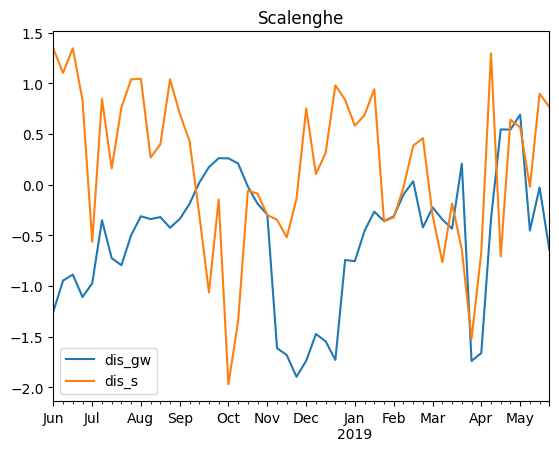

In [134]:
sensor_idx = 10
sensor = ds.sensor_id_list[sensor_idx]

# true_ds[sensor].plot(label = "Y_true")
# pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
#lag_gw_ds[sensor].plot(label = "lag_gw")
plt.title(ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"munic"].values[0])
plt.legend()
plt.show()

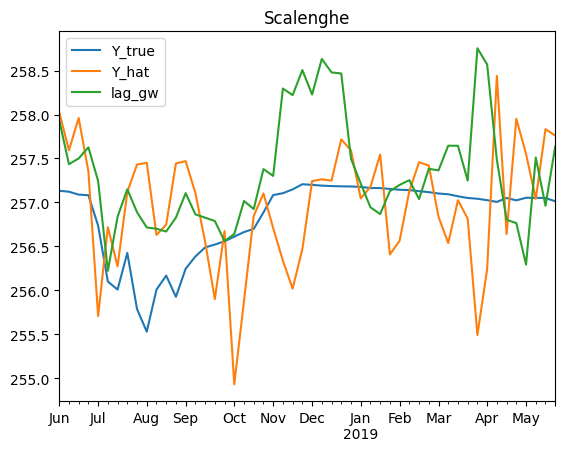

In [133]:
sensor_idx = 10
sensor = ds.sensor_id_list[sensor_idx]

true_ds[sensor].plot(label = "Y_true")
pred_ds[sensor].plot(label = "Y_hat")
# dis_gw_ds[sensor].plot(label = "dis_gw")
# dis_s_ds[sensor].plot(label = "dis_s")
lag_gw_ds[sensor].plot(label = "lag_gw")
plt.title(ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"munic"].values[0])
plt.legend()
plt.show()

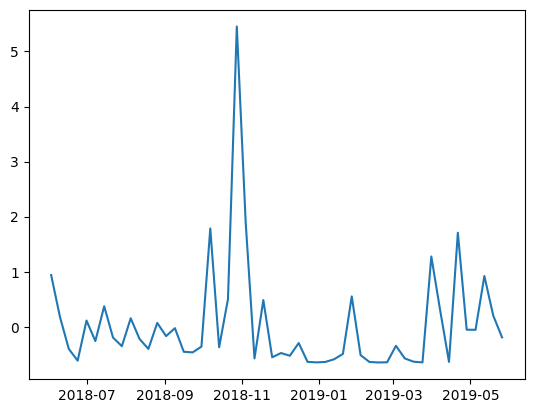

In [135]:
plt.plot(true_ds[sensor].index,
         mean_prec, label = "prec")

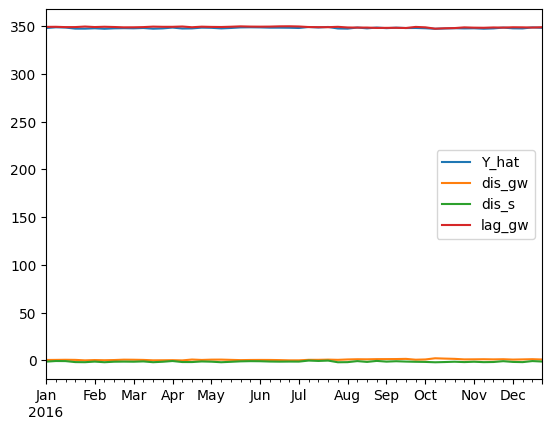

In [54]:
sensor_idx = 0
sensor = ds.sensor_id_list[sensor_idx]

pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
lag_gw_ds[sensor].plot(label = "lag_gw")
plt.legend()
plt.show()

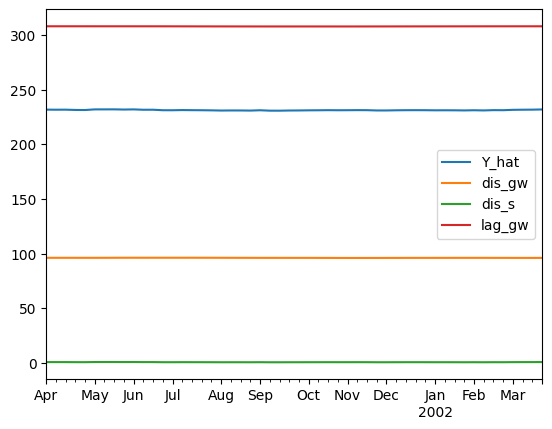

In [ ]:
sensor_idx = 3
sensor = ds.sensor_id_list[sensor_idx]

pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
lag_gw_ds[sensor].plot(label = "lag_gw")
plt.legend()
plt.show()

[]

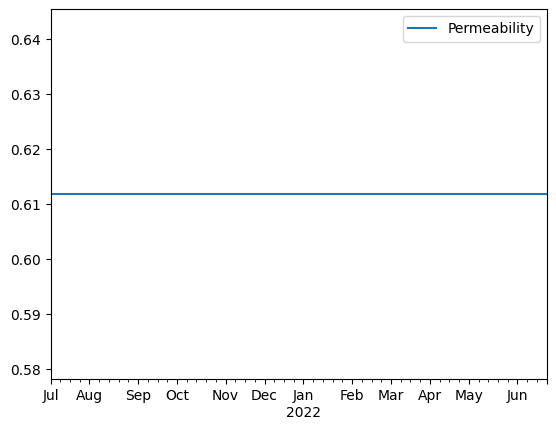

In [30]:
permeability_ds[sensor].plot(label = "Permeability")
plt.legend()
plt.plot()

# Old

In [ ]:
pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions, ds, start_date=np.datetime64("2001-04-01"), n_pred=n_pred, sensor_names=ds.sensor_id_list)
pred_iter_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions_iter, ds, start_date=np.datetime64("2001-04-01"), n_pred=n_pred, sensor_names=ds.sensor_id_list)
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true, ds, start_date=np.datetime64("2001-04-01"), n_pred=n_pred, sensor_names=ds.sensor_id_list)

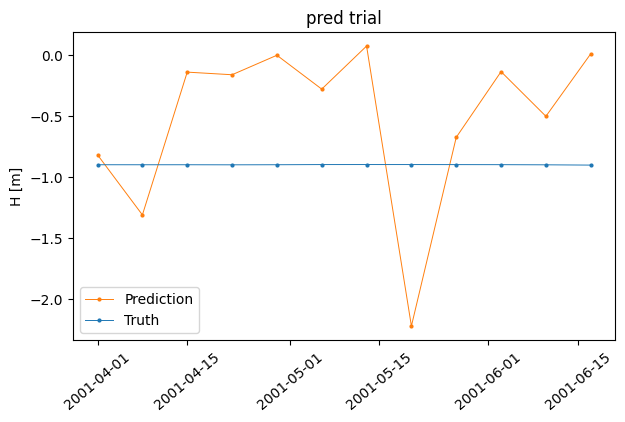

In [34]:
sensor = 3
sensor_id = ds.sensor_id_list[sensor]
plot_ST_MultiPoint.plot_time_series(pred_iter_ds[sensor_id],
                                    true_ds[sensor_id],
                                    title = "pred trial",
                                    print_plot=True)

In [35]:
lat_points = 42
lon_points = 62
Z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [36]:
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12,
                                                Z_grid = Z_grid)

100%|██████████| 12/12 [00:18<00:00,  1.50s/it]


In [37]:
predictions.shape

torch.Size([12, 2604])

In [38]:
predictions_grid = predictions.reshape(12,lat_points,lon_points)

In [40]:
true, predictions_iter = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12, iter_pred = True,
                                                     Z_grid = Z_grid)

100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


In [41]:
predictions_iter_grid = predictions_iter.reshape(12,lat_points,lon_points)

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

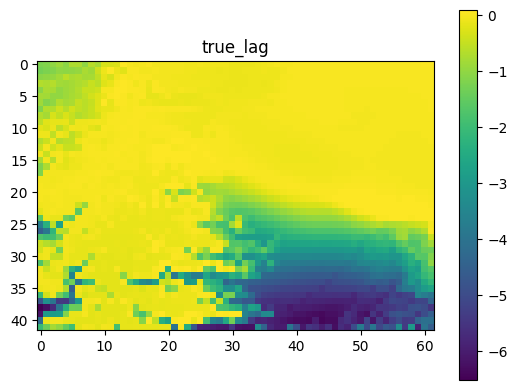

In [42]:
plt.imshow(predictions_grid[5,:,:])
plt.colorbar()
plt.title("true_lag")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

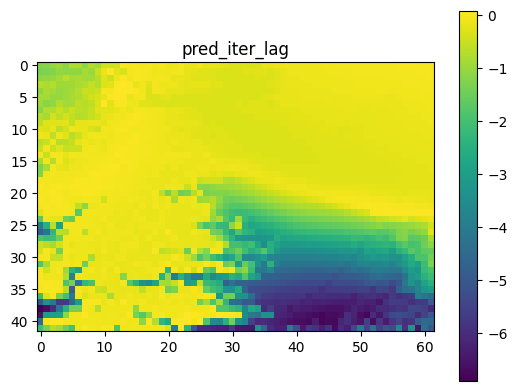

In [43]:
plt.imshow(predictions_iter_grid[5,:,:])
plt.colorbar()
plt.title("pred_iter_lag")
plt.plot

In [81]:
predictions_iter_grid.shape

torch.Size([12, 42, 62])

In [82]:
Z_grid.shape

(2604, 3)

In [84]:
Z_grid_reshape = Z_grid.reshape(lat_points,lon_points,3)
Z_grid_reshape.shape

(42, 62, 3)

In [ ]:
Z_grid_reshape[:,0,0] # lat
Z_grid_reshape[0,:,1] # lon

array([ 1.40201997,  1.32991321,  1.25780645,  1.18569968,  1.11359292,
        1.04148616,  0.96937939,  0.89727263,  0.82516587,  0.7530591 ,
        0.68095234,  0.60884558,  0.53673881,  0.46463205,  0.39252529,
        0.32041852,  0.24831176,  0.176205  ,  0.10409824,  0.03199147,
       -0.04011529, -0.11222205, -0.18432882, -0.25643558, -0.32854234,
       -0.40064911, -0.47275587, -0.54486263, -0.6169694 , -0.68907616,
       -0.76118292, -0.83328969, -0.90539645, -0.97750321, -1.04960997,
       -1.12171674, -1.1938235 , -1.26593026, -1.33803703, -1.41014379,
       -1.48225055, -1.55435732])

In [92]:
#np.datetime64("2001-04-01"), 12
start_date_idx = ds.dates.get_loc(np.datetime64("2001-04-01"))
dates = [ds.dates[start_date_idx+i] for i in range(12)]
dates

[Timestamp('2001-04-01 00:00:00'),
 Timestamp('2001-04-08 00:00:00'),
 Timestamp('2001-04-15 00:00:00'),
 Timestamp('2001-04-22 00:00:00'),
 Timestamp('2001-04-29 00:00:00'),
 Timestamp('2001-05-06 00:00:00'),
 Timestamp('2001-05-13 00:00:00'),
 Timestamp('2001-05-20 00:00:00'),
 Timestamp('2001-05-27 00:00:00'),
 Timestamp('2001-06-03 00:00:00'),
 Timestamp('2001-06-10 00:00:00'),
 Timestamp('2001-06-17 00:00:00')]

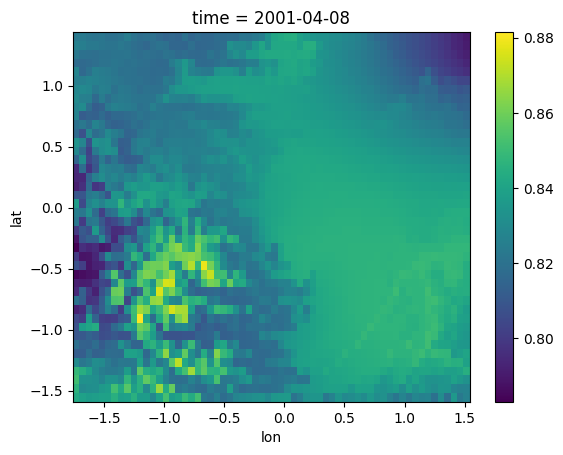

In [96]:
predictions_iter_xr = xarray.DataArray(data = predictions_iter_grid,
                                coords = dict(
                                            lat=("lat", Z_grid_reshape[:,0,0]),
                                            lon=("lon", Z_grid_reshape[0,:,1]),
                                            time=dates),
                                dims = ["time","lat", "lon"]
                                )
predictions_iter_xr[1].plot()

In [100]:
ds.norm_factors["dtm_mean"].values

array(1139.4907, dtype=float32)

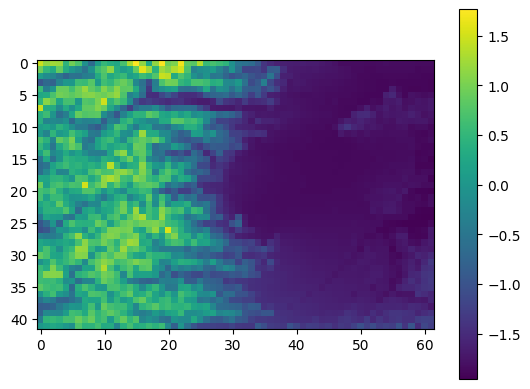

In [103]:
plt.imshow(Z_grid_reshape[:,:,2] - predictions_iter_xr[1])
plt.colorbar()

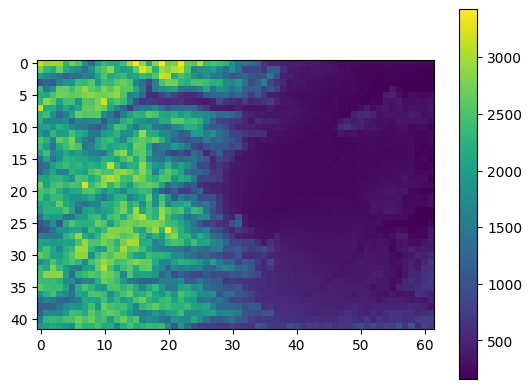

In [102]:
plt.imshow((Z_grid_reshape[:,:,2]*ds.norm_factors["dtm_std"].values) + ds.norm_factors["dtm_mean"].values)
plt.colorbar()

In [108]:
def plot_map(predictions_xr, true_xr,
                 title,
                 x_label = "WTD",
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(title)
    
    vmin = vmin if vmin is not None else true_xr.min().values
    vmax = vmax if vmax is not None else true_xr.max().values

    predictions_xr.plot(ax = ax[0],
                vmin = vmin,
                vmax = vmax)
    ax[0].set_title(f"Prediction {x_label} [m]")

    true_xr.plot(ax = ax[1],
                vmin = vmin,
                vmax = vmax)
    ax[1].set_title(f"True {x_label} [m]")

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

In [109]:
predictions_iter_xr.min()

<xarray.DataArray ()> Size: 4B
array(-1.1965674, dtype=float32)

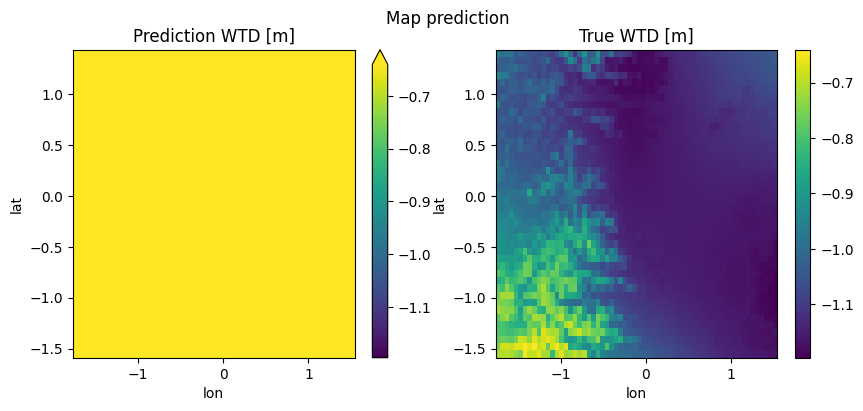

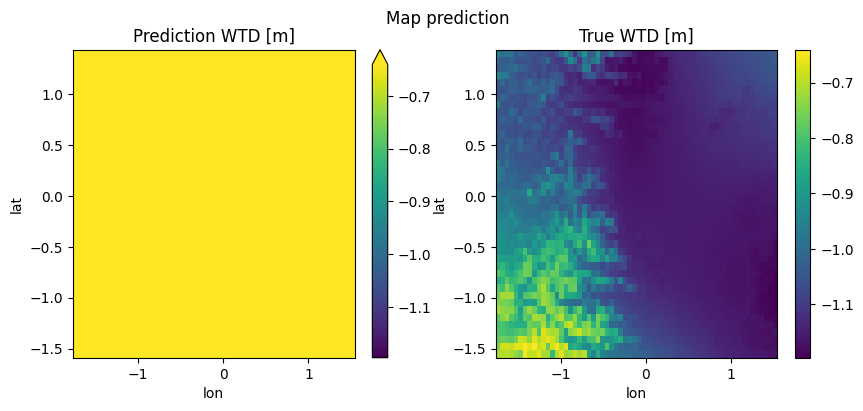

In [ ]:
plot_map(predictions_iter_xr[0],
         predictions_iter_xr[10],
                 title = f"Map prediction",
                 x_label = "WTD",
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = False)

## Load trained model

In [83]:
model_name_path = "model_SparseData_Transformer_20250717_171819" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

RuntimeError: Error(s) in loading state_dict for ST_MultiPoint_DisNet_K:
	Missing key(s) in state_dict: "Value_Embedding_GW.ST_layers.0.weight", "Value_Embedding_GW.ST_layers.0.bias", "Value_Embedding_GW.ST_layers.2.weight", "Value_Embedding_GW.ST_layers.2.bias", "Value_Embedding_GW.ST_layers.4.weight", "Value_Embedding_GW.ST_layers.4.bias", "Value_Embedding_Weather.ST_layers.0.weight", "Value_Embedding_Weather.ST_layers.0.bias", "Value_Embedding_Weather.ST_layers.2.weight", "Value_Embedding_Weather.ST_layers.2.bias", "Value_Embedding_Weather.ST_layers.4.weight", "Value_Embedding_Weather.ST_layers.4.bias", "ST_coords_Embedding.ST_layers.0.weight", "ST_coords_Embedding.ST_layers.0.bias", "ST_coords_Embedding.ST_layers.2.weight", "ST_coords_Embedding.ST_layers.2.bias", "ST_coords_Embedding.ST_layers.4.weight", "ST_coords_Embedding.ST_layers.4.bias", "HydrConductivity.ST_layers.0.weight", "HydrConductivity.ST_layers.0.bias", "HydrConductivity.ST_layers.2.weight", "HydrConductivity.ST_layers.2.bias", "HydrConductivity.ST_layers.4.weight", "HydrConductivity.ST_layers.4.bias", "HydrConductivity_Linear.0.weight", "GW_lags_Module.multihead_att.in_proj_weight", "GW_lags_Module.multihead_att.in_proj_bias", "GW_lags_Module.multihead_att.out_proj.weight", "GW_lags_Module.multihead_att.out_proj.bias", "GW_lags_Module.norm_linear.0.weight", "GW_lags_Module.norm_linear.0.bias", "GW_lags_Module.norm_linear.2.weight", "GW_lags_Module.norm_linear.2.bias", "GW_lags_Module.norm_linear.4.weight", "GW_lags_Module.norm_linear.4.bias", "Weather_lags_Module.multihead_att.in_proj_weight", "Weather_lags_Module.multihead_att.in_proj_bias", "Weather_lags_Module.multihead_att.out_proj.weight", "Weather_lags_Module.multihead_att.out_proj.bias", "Weather_lags_Module.norm_linear.0.weight", "Weather_lags_Module.norm_linear.0.bias", "Weather_lags_Module.norm_linear.2.weight", "Weather_lags_Module.norm_linear.2.bias", "Weather_lags_Module.norm_linear.4.weight", "Weather_lags_Module.norm_linear.4.bias", "Linear_S.0.weight", "Linear_S.0.bias", "Linear_S.1.weight", "Linear_S.1.bias", "Displacement_Module_GW_0.norm_layer_1.weight", "Displacement_Module_GW_0.norm_layer_1.bias", "Displacement_Module_GW_0.mha.in_proj_weight", "Displacement_Module_GW_0.mha.in_proj_bias", "Displacement_Module_GW_0.mha.out_proj.weight", "Displacement_Module_GW_0.mha.out_proj.bias", "Displacement_Module_GW_0.norm_layer_2.weight", "Displacement_Module_GW_0.norm_layer_2.bias", "Displacement_Module_GW_0.mlp.0.weight", "Displacement_Module_GW_0.mlp.0.bias", "Displacement_Module_GW_0.mlp.2.weight", "Displacement_Module_GW_0.mlp.2.bias", "Displacement_Module_S_0.norm_layer_1.weight", "Displacement_Module_S_0.norm_layer_1.bias", "Displacement_Module_S_0.mha.in_proj_weight", "Displacement_Module_S_0.mha.in_proj_bias", "Displacement_Module_S_0.mha.out_proj.weight", "Displacement_Module_S_0.mha.out_proj.bias", "Displacement_Module_S_0.norm_layer_2.weight", "Displacement_Module_S_0.norm_layer_2.bias", "Displacement_Module_S_0.mlp.0.weight", "Displacement_Module_S_0.mlp.0.bias", "Displacement_Module_S_0.mlp.2.weight", "Displacement_Module_S_0.mlp.2.bias", "Displacement_Module_GW_1.norm_layer_1.weight", "Displacement_Module_GW_1.norm_layer_1.bias", "Displacement_Module_GW_1.mha.in_proj_weight", "Displacement_Module_GW_1.mha.in_proj_bias", "Displacement_Module_GW_1.mha.out_proj.weight", "Displacement_Module_GW_1.mha.out_proj.bias", "Displacement_Module_GW_1.norm_layer_2.weight", "Displacement_Module_GW_1.norm_layer_2.bias", "Displacement_Module_GW_1.mlp.0.weight", "Displacement_Module_GW_1.mlp.0.bias", "Displacement_Module_GW_1.mlp.2.weight", "Displacement_Module_GW_1.mlp.2.bias", "Displacement_Module_S_1.norm_layer_1.weight", "Displacement_Module_S_1.norm_layer_1.bias", "Displacement_Module_S_1.mha.in_proj_weight", "Displacement_Module_S_1.mha.in_proj_bias", "Displacement_Module_S_1.mha.out_proj.weight", "Displacement_Module_S_1.mha.out_proj.bias", "Displacement_Module_S_1.norm_layer_2.weight", "Displacement_Module_S_1.norm_layer_2.bias", "Displacement_Module_S_1.mlp.0.weight", "Displacement_Module_S_1.mlp.0.bias", "Displacement_Module_S_1.mlp.2.weight", "Displacement_Module_S_1.mlp.2.bias", "Linear_Lag.0.weight", "Linear_Lag.0.bias", "Linear_2_GW.0.weight", "Linear_2_GW.0.bias", "GW_diffusion.0.weight", "GW_diffusion.0.bias", "GW_diffusion.1.weight", "GW_diffusion.1.bias", "GW_diffusion.3.weight", "GW_diffusion.3.bias", "GW_diffusion.4.weight", "GW_diffusion.4.bias", "GW_diffusion.6.weight", "GW_diffusion.6.bias", "GW_diffusion.7.weight", "GW_diffusion.7.bias", "GW_diffusion.9.weight", "GW_diffusion.9.bias", "Linear_2_S.0.weight", "Linear_2_S.0.bias". 
	Unexpected key(s) in state_dict: "SparseAutoreg_Module.topo_embeddings.0.weight", "SparseAutoreg_Module.topo_embeddings.0.bias", "SparseAutoreg_Module.value_embeddings.0.weight", "SparseAutoreg_Module.value_embeddings.0.bias", "SparseAutoreg_Module.cb_multihead_att_1.in_proj_weight", "SparseAutoreg_Module.cb_multihead_att_1.in_proj_bias", "SparseAutoreg_Module.cb_multihead_att_1.out_proj.weight", "SparseAutoreg_Module.cb_multihead_att_1.out_proj.bias", "SparseAutoreg_Module.norm_linear.0.weight", "SparseAutoreg_Module.norm_linear.0.bias", "SparseAutoreg_Module.norm_linear.2.weight", "SparseAutoreg_Module.norm_linear.2.bias", "ST_Conditioning_Module.ST_layers.0.weight", "ST_Conditioning_Module.ST_layers.0.bias", "ST_Conditioning_Module.ST_layers.2.weight", "ST_Conditioning_Module.ST_layers.2.bias", "ST_Conditioning_Module.ST_layers.4.weight", "ST_Conditioning_Module.ST_layers.4.bias", "Weather_Module.topo_embeddings.0.weight", "Weather_Module.topo_embeddings.0.bias", "Weather_Module.value_embeddings.0.weight", "Weather_Module.value_embeddings.0.bias", "Weather_Module.cb_multihead_att_1.in_proj_weight", "Weather_Module.cb_multihead_att_1.in_proj_bias", "Weather_Module.cb_multihead_att_1.out_proj.weight", "Weather_Module.cb_multihead_att_1.out_proj.bias", "Weather_Module.norm_linear.0.weight", "Weather_Module.norm_linear.0.bias", "Weather_Module.norm_linear.2.weight", "Weather_Module.norm_linear.2.bias", "Fusion_Embedding.0.weight", "Fusion_Embedding.0.bias", "MHA_Block_0.mha.in_proj_weight", "MHA_Block_0.mha.in_proj_bias", "MHA_Block_0.mha.out_proj.weight", "MHA_Block_0.mha.out_proj.bias", "MHA_Block_0.mlp.0.weight", "MHA_Block_0.mlp.0.bias", "MHA_Block_0.mlp.2.weight", "MHA_Block_0.mlp.2.bias", "linear.0.weight", "linear.0.bias", "output.0.weight", "output.0.bias", "output.2.weight", "output.2.bias". 

In [60]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [61]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

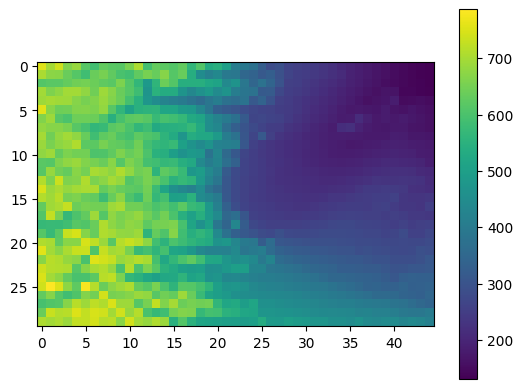

In [66]:
plt.imshow(Y_hat_test_grid[3,:,:])
plt.colorbar()

# Loss

In [36]:
prova = torch.arange(0,10).unsqueeze(0).repeat((10,1))[None,None,:,:].to(torch.float32)
print(prova, end = "\n\n")
print(Fdiff_conv(prova, mode = "first_lat"), end = "\n\n")
print(Fdiff_conv(prova, mode = "first_lon"), end = "\n\n")

tensor([[[[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]]])

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

In [37]:
Fdiff_conv(prova, mode = "first_lon").shape

torch.Size([1, 1, 10, 10])

In [147]:
from loss import losses_SparseData
importlib.reload(losses_SparseData)

<module 'loss.losses_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/loss/losses_SparseData.py'>

In [137]:
batch_s = 5
x_batch = torch.stack([ds[i][0] for i in range(batch_s)], dim = 0)
z_batch = torch.stack([ds[i][1] for i in range(batch_s)], dim = 0)
w0_batch = torch.stack([ds[0][2][0] for i in range(batch_s)], dim = 0)
w1_batch = torch.stack([ds[0][2][1] for i in range(batch_s)], dim = 0)
w_batch = [w0_batch, w1_batch]
true_batch = torch.stack([ds[i][-3] for i in range(batch_s)], dim = 0)
xmask_batch = torch.stack([ds[i][-2] for i in range(batch_s)], dim = 0)
ymask_batch = torch.stack([ds[i][-1] for i in range(batch_s)], dim = 0)

In [138]:
model.train()
out_batch = model(x_batch,
                  z_batch,
                  w_batch,
                  xmask_batch,
                       teacher_forcing = True)

In [139]:
norm_factor = [torch.tensor(ds.norm_factors["target_means"]).to(out_batch.device).to(torch.float32),
            torch.tensor(ds.norm_factors["target_stds"]).to(out_batch.device).to(torch.float32)
            ]

In [87]:
out_batch.shape

torch.Size([5, 26, 28])

In [92]:
true_batch.shape

torch.Size([5, 26, 28])

In [155]:
losses_SparseData.loss_masked_h2(out_batch, true_batch, ymask_batch,
            norm_factor)

tensor([[[ 90.5781,  92.5830, 174.8781,  ...,  29.5957,  22.5359,  22.7983],
         [-64.9565, 140.8301, 129.6301,  ..., 140.9766, -96.3849, -89.1852],
         [365.5546, 294.0675, 331.7056,  ..., 175.5725, -87.6100, -76.2506],
         ...,
         [132.6866, 142.8001, 102.6010,  ..., 179.1476, 217.8306, 159.3986],
         [144.0751, 129.7386, 119.3159,  ..., 178.4463, 214.8107, 164.2427],
         [ 94.8056, 176.8314, 163.9642,  ..., 208.4325, 158.4632, 236.5394]],

        [[606.7235, 489.5417, 328.0421,  ..., 177.7885, 223.4379, 154.7892],
         [406.4716, 359.2103, 241.4683,  ..., 133.3777,  28.8863,  31.6063],
         [681.2541, 538.9100, 276.3175,  ...,   3.5021, 166.3419, 149.5751],
         ...,
         [233.0011, 172.5778, 160.3578,  ..., 268.0643, 193.9412, 220.2015],
         [261.3091, 267.8188, 282.5597,  ..., 237.8039, 175.3546, 191.8213],
         [260.9424, 256.3831, 264.4753,  ..., 270.7410, 223.3766, 209.6097]],

        [[405.7957, 393.7622, 336.9928,  ...

tensor(453407.5312, grad_fn=<DivBackward0>)

In [150]:
h2_denorm = losses_SparseData.point_h2((out_batch* norm_factor[1]) + norm_factor[0],
         (true_batch* norm_factor[1]) + norm_factor[0],
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [151]:
h2_norm = losses_SparseData.point_h2(out_batch,
         true_batch,
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [156]:
Y_tstep_avail_mask = (torch.sum(ymask_batch, dim = 1) > 1)
Y_tstep_avail_mask.shape

torch.Size([5, 28])

In [157]:
torch.sum(h2_denorm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(453407.5312, grad_fn=<DivBackward0>)

In [158]:
torch.sum(h2_norm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(1748253.1250, grad_fn=<DivBackward0>)